In [1]:
#               __  ___  _      __                ___              _     ___                    _      ___     _            _   _             
#              /__\/   \/_\    / _| ___  _ __    / __\__ _ _ __ __| |   / __\ __ __ _ _   _  __| |    /   \___| |_ ___  ___| |_(_) ___  _ __  
#             /_\ / /\ //_\\  | |_ / _ \| '__|  / /  / _` | '__/ _` |  / _\| '__/ _` | | | |/ _` |   / /\ / _ \ __/ _ \/ __| __| |/ _ \| '_ \ 
#            //__/ /_//  _  \ |  _| (_) | |    / /__| (_| | | | (_| | / /  | | | (_| | |_| | (_| |  / /_//  __/ ||  __/ (__| |_| | (_) | | | |
#            \__/___,'\_/ \_/ |_|  \___/|_|    \____/\__,_|_|  \__,_| \/   |_|  \__,_|\__,_|\__,_| /___,' \___|\__\___|\___|\__|_|\___/|_| |_|

Credit Card Fraud Detection is a classic class-imbalance problem where the number of fraud transactions is much lesser than the number of legitimate transaction for any bank. Most of the approaches involve building model on such imbalanced data, and thus fails to produce results on real-time new data because of overfitting on training data and a bias towards the majoritarian class of legitimate transactions. Thus, we can see this as an anomaly detection problem.

1. What time does the Credit Card Frauds usually take place?
2. What are the general trends of amounts for Credit Card Fraud Transactions?
3. How do we balance the data to not let the model overfit on legitimate transactions?

In [2]:
# Libraries are imported.
from matplotlib import pyplot as plt
from datetime import datetime
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------> Data pre-processing <-------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
# Reading the dataset.
df_train = pd.read_csv('/Volumes/ALEJANDRO/S.E./Credit-Card-Fraud-Detection/Datasets/training.csv')
# The column with the index number is being deleted.
df_train.drop(df_train.columns[0], axis = 1, inplace = True)

In [5]:
# The first 10 rows were printed.
print(df_train.head(10))

  trans_date_trans_time               cc_num  \
0   2019-08-08 06:53:43  4503101193493052864   
1   2020-03-04 01:33:46        4198470814557   
2   2019-12-20 08:16:46     3560318482131952   
3   2019-09-08 16:13:21     4683520018489354   
4   2019-12-13 11:27:09      377993105397617   
5   2020-08-11 08:20:16      345389171551808   
6   2020-03-05 19:39:47      371034293500716   
7   2019-10-31 16:39:47     4610050989831291   
8   2019-05-26 12:43:25     4509142395811241   
9   2020-12-18 06:29:16      372246459334925   

                                      merchant        category     amt  \
0                       fraud_Bahringer-Larson     grocery_net   46.65   
1                              fraud_Brown PLC        misc_net  873.73   
2                        fraud_Cummerata-Jones   gas_transport   75.98   
3                             fraud_Fisher Inc    shopping_net    4.70   
4  fraud_Christiansen, Goyette and Schamberger   gas_transport   72.31   
5                          

In [6]:
# The columns were printed.
print(df_train.columns)

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')


In [7]:
# First it is necessary to drop all the duplicate values. Although, the shell script is in charge of that.
df_train = df_train.copy()
df_train.drop_duplicates(inplace = True)
print("Duplicated values dropped successfully")

Duplicated values dropped successfully


In [8]:
# Some columns get renamed.
df_train.rename(columns = {'trans_date_trans_time':'transaction_time',
                         'cc_num':'credit_card_number',
                         'amt':'amount(usd)',
                         'trans_num':'transaction_id'},
                inplace = True)

In [9]:
# The datetime columns were converted.
# transaction_time and dob should be in pd.datetime format and we also convert unix_time to exact timestamp
df_train['transaction_time'] = pd.to_datetime(df_train['transaction_time'], infer_datetime_format = True)
df_train['dob'] = pd.to_datetime(df_train['dob'], infer_datetime_format = True)

In [10]:
# A function was applied utcfromtimestamp and was dropped column unix_time
df_train['time'] = df_train['unix_time'].apply(datetime.utcfromtimestamp)
df_train.drop('unix_time', axis=1)
# A column with hour of day was added.
df_train['hour_of_day'] = df_train.time.dt.hour

In [16]:
# Credit card number should be integers not dtypes.
# Change dtypes
df_train.credit_card_number = df_train.credit_card_number.astype('category')
df_train.is_fraud = df_train.is_fraud.astype('category')
df_train.hour_of_day = df_train.hour_of_day.astype('category')
# Check
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481915 entries, 0 to 1481914
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   transaction_time    1481915 non-null  datetime64[ns]
 1   credit_card_number  1481915 non-null  category      
 2   merchant            1481915 non-null  object        
 3   category            1481915 non-null  object        
 4   amount(usd)         1481915 non-null  float64       
 5   first               1481915 non-null  object        
 6   last                1481915 non-null  object        
 7   gender              1481915 non-null  object        
 8   street              1481915 non-null  object        
 9   city                1481915 non-null  object        
 10  state               1481915 non-null  object        
 11  zip                 1481915 non-null  int64         
 12  lat                 1481915 non-null  float64       
 13  long        

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------> End or data preprocessing <-------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------> Unbalanced data check <------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
# The  number of classes got counted, in this case, fraudulent or not.
df_train['is_fraud'].value_counts()

0    1474189
1       7726
Name: is_fraud, dtype: int64

In [13]:
# Labeling the data in genuine and fraudulent transactions, this way it is easier to observe that the data is unbalanced.
labels=["Genuine", "Fraud"]
fraud_or_not = df_train['is_fraud'].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]
# Plotting the values.
fig = px.pie(values = df_train['is_fraud'].value_counts(), names = labels , width = 700, height = 400, color_discrete_sequence = ["skyblue", "black"]
             ,title = "Fraud vs Genuine transactions")
fig.show()

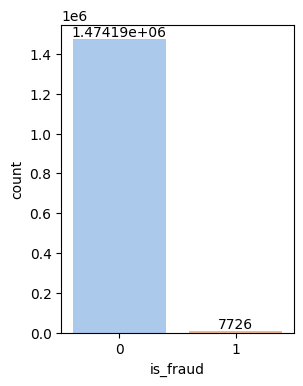

In [14]:
# Unbalance data represented with bars.
plt.figure(figsize = (3,4))
ax = sns.countplot(x = 'is_fraud', data = df_train, palette = "pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [15]:
# Percentage of data.
print('Genuine transactions:', round(df_train['is_fraud'].value_counts()[0]/len(df_train) * 100,2), '% of the dataset')
print('Fraudulent transactions:', round(df_train['is_fraud'].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

Genuine transactions: 99.48 % of the dataset
Fraudulent transactions: 0.52 % of the dataset
